In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from math import radians, cos, sin, asin, sqrt
import folium
from folium import plugins

In [ ]:
traffic_df = pd.read_csv("/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/processed/traffic.csv")
congestion_zones_df = pd.read_csv('/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/cleaned/congestion_zones.csv')
stops_df = pd.read_csv('/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/cleaned/cleaned_bus_stops_file.csv')
routes_df = pd.read_csv('/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/cleaned/cleaned_bus_routes_file.csv')

print(f"Loaded {len(traffic_df):,} traffic records")
print(f"Loaded {len(stops_df)} bus stops")
print(f"Loaded {len(routes_df)} bus routes\n")

Loaded 1,549,600 traffic records
Loaded 4674 bus stops
Loaded 578 bus routes



ROUTE-SPECIFIC TRAFFIC ANALYSIS

In [ ]:
print("\n" + "="*80)
print("STEP 4: ROUTE-SPECIFIC TRAFFIC ANALYSIS")
print("="*80 + "\n")

def get_traffic_near_route(route_coords, traffic_data, buffer=0.003):
    """Extract traffic data within buffer distance of route"""
    route_traffic = []

    for coord in route_coords:
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            lon, lat = coord
            nearby = traffic_data[
                (abs(traffic_data['lat'] - lat) < buffer) &
                (abs(traffic_data['lon'] - lon) < buffer)
            ].copy()

            if not nearby.empty:
                nearby['route_lat'] = lat
                nearby['route_lon'] = lon
                route_traffic.append(nearby)

    if route_traffic:
        return pd.concat(route_traffic, ignore_index=True)
    return pd.DataFrame()

# Analyze traffic for each bus route
route_traffic_dict = {}

print("Analyzing traffic patterns for each route...")
for idx, route in routes_df.iterrows():
    # route_id = route['ref'] if pd.notna(route['ref']) else str(route['route_id'])
    route_id = str(route['route_id'])

    # Manually parse the string representation of the list of coordinates
    try:
        # Remove brackets and split by comma, then convert to float pairs
        coords_str = route['coordinates'].strip('[]')
        coords = []
        for pair_str in coords_str.split('], ['):
            lon_str, lat_str = pair_str.strip('[]').split(',')
            coords.append([float(lon_str), float(lat_str)])

        if not isinstance(coords, list):
             coords = [] # Should not happen with manual parsing, but safety
    except Exception as e:
        print(f"Error parsing coordinates for route {route_id}: {e}")
        coords = [] # Handle any parsing errors


    route_traffic = get_traffic_near_route(coords, traffic_df)

    if not route_traffic.empty and len(route_traffic) > 1000:
        route_traffic_dict[route_id] = route_traffic
        print(f"   Route {route_id}: {len(route_traffic):,} traffic points")



STEP 4: ROUTE-SPECIFIC TRAFFIC ANALYSIS

Analyzing traffic patterns for each route...
   Route 1700755: 2,481 traffic points
   Route 1701250: 2,481 traffic points
   Route 1701251: 19,763 traffic points
   Route 2148296: 13,254 traffic points
   Route 2170840: 34,502 traffic points
   Route 2172576: 43,602 traffic points
   Route 2172595: 59,420 traffic points
   Route 2174648: 55,420 traffic points
   Route 2341849: 12,979 traffic points
   Route 2341850: 38,620 traffic points
   Route 2341851: 28,715 traffic points
   Route 2446915: 69,804 traffic points
   Route 2447814: 95,033 traffic points
   Route 2465747: 48,320 traffic points
   Route 2466740: 16,298 traffic points
   Route 2474122: 37,942 traffic points
   Route 2793245: 2,377 traffic points
   Route 3088576: 22,509 traffic points
   Route 3088610: 9,799 traffic points
   Route 3999294: 31,064 traffic points
   Route 3999295: 26,381 traffic points
   Route 3999302: 23,842 traffic points
   Route 3999303: 24,246 traffic poin

In [ ]:
with open('content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/route_specific_traffic.pkl', 'wb') as f:
    pickle.dump(route_traffic_dict, f)

In [ ]:
if not route_traffic_dict:
    print("No routes with sufficient traffic data. Using all traffic data.")
    main_route_id = "All Routes"
    main_route_traffic = traffic_df
else:
    # Select route with most traffic data
    main_route_id = max(route_traffic_dict.keys(), key=lambda x: len(route_traffic_dict[x]))
    main_route_traffic = route_traffic_dict[main_route_id]

print(f"\nMain route for detailed analysis: Route {main_route_id}")
print(f"   Traffic records: {len(main_route_traffic):,}")


Main route for detailed analysis: Route 16936023
   Traffic records: 125,578


 MODEL TESTING & COMPARISON (RF vs XGBoost vs Linear)


Dataset Split:
   Training samples: 80,000
   Test samples: 20,000

Training Linear Regression...
Linear Regression Results:
   MAE  : 11.442 km/h
   RMSE : 17.208 km/h
   R²   : 0.233
   CV MAE (mean): 11.420 ± 0.049
   CV R²  (mean): 0.232 ± 0.002

Training Random Forest...
Random Forest Results:
   MAE  : 6.551 km/h
   RMSE : 11.282 km/h
   R²   : 0.670
   CV MAE (mean): 6.527 ± 0.046
   CV R²  (mean): 0.671 ± 0.005

Training XGBoost...
XGBoost Results:
   MAE  : 6.011 km/h
   RMSE : 10.589 km/h
   R²   : 0.710
   CV MAE (mean): 5.981 ± 0.035
   CV R²  (mean): 0.712 ± 0.005



,Model,MAE,RMSE,R²,CV_MAE (mean),CV_R² (mean)
2,XGBoost,6.011121,10.588736,0.709505,5.981436,0.711815
1,Random Forest,6.550604,11.281783,0.670234,6.526889,0.671460
0,Linear Regression,11.441992,17.207772,0.232817,11.419889,0.232175


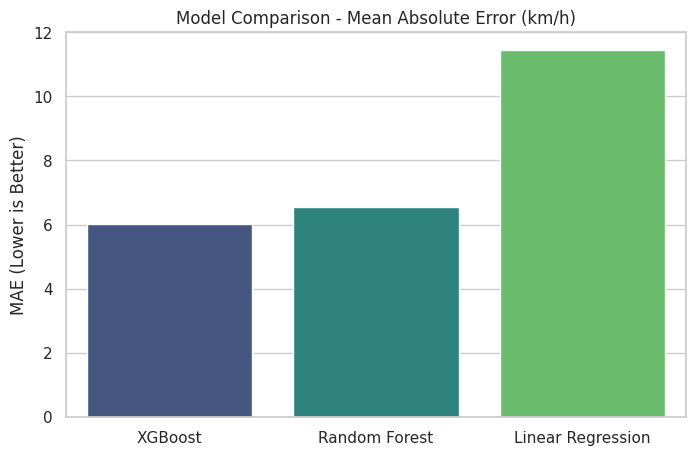

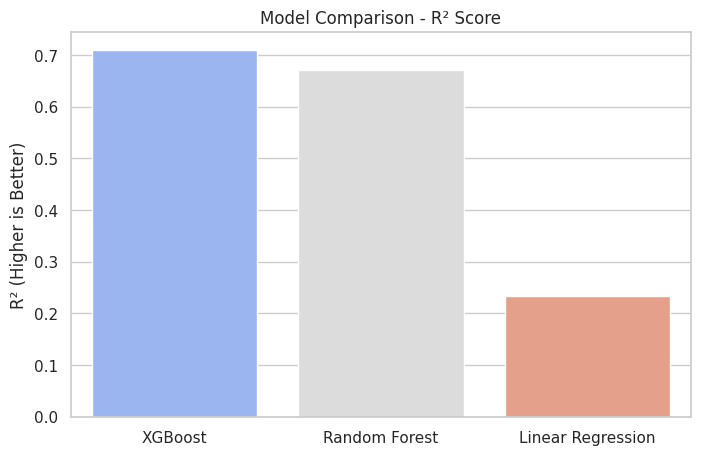

In [ ]:

sns.set(style="whitegrid")

feature_columns = [
    'lat', 'lon', 'heading', 'hour', 'day_of_week', 'is_weekend',
    'is_rush_hour', 'lat_grid', 'lon_grid', 'distance_from_center',
    'distance_to_congestion', 'congestion_avg_speed'
]

if len(main_route_traffic) > 100000:
    main_route_traffic = main_route_traffic.sample(n=100000, random_state=42)

available_features = [col for col in feature_columns if col in main_route_traffic.columns]

X = main_route_traffic[available_features]
y = main_route_traffic['speed']


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=15, min_samples_split=10,
        random_state=42, n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=150, max_depth=10, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDataset Split:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}\n")

# --- K-Fold setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

# --- Loop through each model ---
for name, model in models.items():
    print("="*60)
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # K-Fold Cross Validation (MAE)
    cv_mae = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "CV_MAE (mean)": cv_mae.mean(),
        "CV_R² (mean)": cv_r2.mean()
    })

    print(f"{name} Results:")
    print(f"   MAE  : {mae:.3f} km/h")
    print(f"   RMSE : {rmse:.3f} km/h")
    print(f"   R²   : {r2:.3f}")
    print(f"   CV MAE (mean): {cv_mae.mean():.3f} ± {cv_mae.std():.3f}")
    print(f"   CV R²  (mean): {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
    print()

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results).sort_values(by="MAE")
display(results_df)

# --- Plot Comparison ---
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="MAE", palette="viridis")
plt.title("Model Comparison - Mean Absolute Error (km/h)")
plt.ylabel("MAE (Lower is Better)")
plt.xlabel("")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="R²", palette="coolwarm")
plt.title("Model Comparison - R² Score")
plt.ylabel("R² (Higher is Better)")
plt.xlabel("")
plt.show()


<Figure size 1000x600 with 0 Axes>

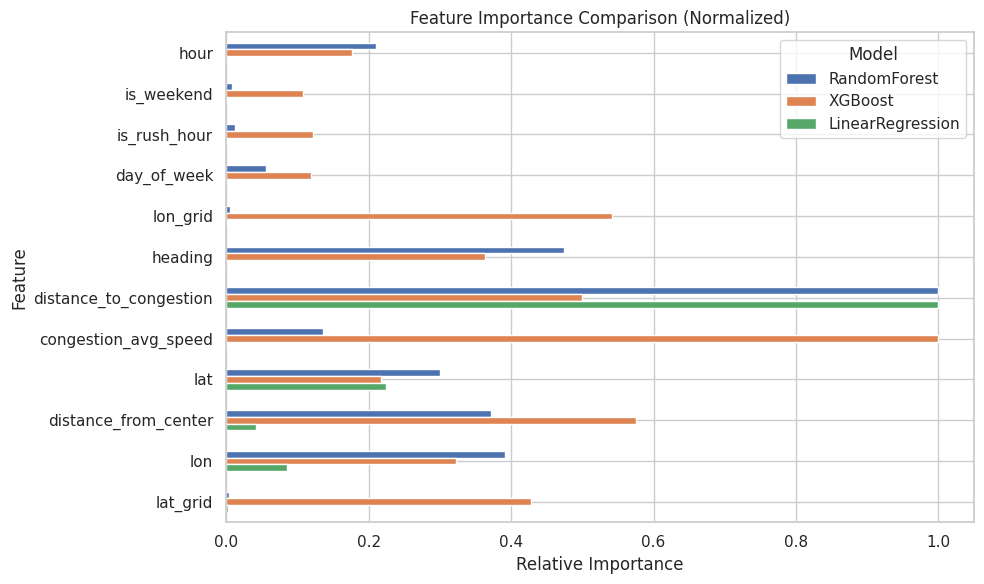

In [ ]:
# --- Random Forest ---
rf_model = models["Random Forest"]
rf_importances = pd.DataFrame({
    "Feature": available_features,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# --- XGBoost ---
xgb_model = models["XGBoost"]
xgb_importances = pd.DataFrame({
    "Feature": available_features,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# --- Linear Regression (absolute coefficient values) ---
lr_model = models["Linear Regression"]
lr_importances = pd.DataFrame({
    "Feature": available_features,
    "Importance": np.abs(lr_model.coef_)
}).sort_values(by="Importance", ascending=False)

# --- Combine for comparison ---
top_features = list(set(
    rf_importances.head(10)["Feature"].tolist() +
    xgb_importances.head(10)["Feature"].tolist() +
    lr_importances.head(10)["Feature"].tolist()
))

importance_df = pd.DataFrame({
    "Feature": top_features,
    "RandomForest": rf_importances.set_index("Feature").reindex(top_features)["Importance"],
    "XGBoost": xgb_importances.set_index("Feature").reindex(top_features)["Importance"],
    "LinearRegression": lr_importances.set_index("Feature").reindex(top_features)["Importance"],
}).fillna(0)

importance_df


In [ ]:
# --- Normalize for fair visual comparison ---
importance_df.iloc[:, 1:] = importance_df.iloc[:, 1:].div(importance_df.iloc[:, 1:].max())

# --- Plot side-by-side ---
plt.figure(figsize=(10,6))
importance_df.set_index("Feature").plot(kind="barh", figsize=(10,6))
plt.title("Feature Importance Comparison (Normalized)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

MACHINE LEARNING MODELS (PREDICTIVE ANALYTICS)

In [ ]:
import pickle
print("\n" + "="*80)
print("STEP 6: MACHINE LEARNING - PREDICTIVE ANALYTICS")
print("="*80 + "\n")

print("Training machine learning models to predict traffic speeds...")

# Prepare features
feature_columns = ['lat', 'lon', 'heading', 'hour', 'day_of_week', 'is_weekend',
       'is_rush_hour', 'lat_grid', 'lon_grid', 'distance_from_center',
       'distance_to_congestion','congestion_avg_speed'
]

route_models = {}

for route_id, route_traffic in route_traffic_dict.items():
    print(f"\nTraining models for route {route_id}...")
    if len(route_traffic) > 200000:
        route_traffic = route_traffic.sample(n=200000, random_state=42)

    # Ensure feature columns exist in the DataFrame
    available_features = [col for col in feature_columns if col in route_traffic.columns]
    if not available_features:
        print(f"   No features available for route {route_id}. Skipping.")
        continue

    X = route_traffic[available_features]
    y = route_traffic['speed']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nDataset Split:")
    print(f"   Training samples: {len(X_train):,}")
    print(f"   Test samples: {len(X_test):,}")

    # Initialize and train the model
    model = xgb.XGBRegressor(
        n_estimators=150, max_depth=10, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model.fit(X, y)

    print(f"\nXGB Regression:")
    print(f"   MAE: {mae:.3f} km/h")
    print(f"   R²: {r2:.3f}")
    route_models[route_id] = {
        'model': model,
        'mae': mae,
        'r2': r2,
        'data_points': len(route_traffic),
        'features_used': available_features # Store features used for this model
    }

Streaming output truncated to the last 5000 lines.

Training models for route 13526527...

Dataset Split:
   Training samples: 58,348
   Test samples: 14,587

XGB Regression:
   MAE: 8.104 km/h
   R²: 0.692

Training models for route 13531415...

Dataset Split:
   Training samples: 48,198
   Test samples: 12,050

XGB Regression:
   MAE: 8.054 km/h
   R²: 0.696

Training models for route 13531416...

Dataset Split:
   Training samples: 40,838
   Test samples: 10,210

XGB Regression:
   MAE: 7.318 km/h
   R²: 0.705

Training models for route 13724637...

Dataset Split:
   Training samples: 35,017
   Test samples: 8,755

XGB Regression:
   MAE: 7.300 km/h
   R²: 0.759

Training models for route 13724638...

Dataset Split:
   Training samples: 52,089
   Test samples: 13,023

XGB Regression:
   MAE: 6.455 km/h
   R²: 0.745

Training models for route 13725138...

Dataset Split:
   Training samples: 43,393
   Test samples: 10,849

XGB Regression:
   MAE: 7.216 km/h
   R²: 0.744

Training mode

In [ ]:
avg_r, avg_mae = 0,0
for i,model_info in route_models.items():
  avg_r += model_info['r2']
  avg_mae += model_info['mae']
avg_r /= len(route_models)
avg_mae /= len(route_models)

In [ ]:
import pickle
print("\n" + "="*80)
print("STEP 6: MACHINE LEARNING - PREDICTIVE ANALYTICS")
print("="*80 + "\n")

print("Training machine learning models to predict traffic speeds...")

# Prepare features
feature_columns = ['lat', 'lon', 'heading', 'hour', 'day_of_week', 'is_weekend',
       'is_rush_hour', 'lat_grid', 'lon_grid', 'distance_from_center',
       'distance_to_congestion','congestion_avg_speed'
]

route_models = {}

for route_id, route_traffic in list(route_traffic_dict.items())[:100]:
    print(f"\nTraining models for route {route_id}...")
    if len(route_traffic) > 200000:
        route_traffic = route_traffic.sample(n=200000, random_state=42)

    # Ensure feature columns exist in the DataFrame
    available_features = [col for col in feature_columns if col in route_traffic.columns]
    if not available_features:
        print(f"   No features available for route {route_id}. Skipping.")
        continue

    X = route_traffic[available_features]
    y = route_traffic['speed']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nDataset Split:")
    print(f"   Training samples: {len(X_train):,}")
    print(f"   Test samples: {len(X_test):,}")

    # Initialize and train the model
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nRandom Forest Regression:")
    print(f"   MAE: {mae:.3f} km/h")
    print(f"   R²: {r2:.3f}")
    route_models[route_id] = {
        'model': model,
        'mae': mae,
        'r2': r2,
        'data_points': len(route_traffic),
        'features_used': available_features # Store features used for this model
    }


STEP 6: MACHINE LEARNING - PREDICTIVE ANALYTICS

Training machine learning models to predict traffic speeds...

Training models for route 1700755...

Dataset Split:
   Training samples: 1,984
   Test samples: 497

Random Forest Regression:
   MAE: 4.927 km/h
   R²: 0.755

Training models for route 1701250...

Dataset Split:
   Training samples: 1,984
   Test samples: 497

Random Forest Regression:
   MAE: 5.380 km/h
   R²: 0.659

Training models for route 1701251...

Dataset Split:
   Training samples: 15,810
   Test samples: 3,953

Random Forest Regression:
   MAE: 7.856 km/h
   R²: 0.705

Training models for route 2148296...

Dataset Split:
   Training samples: 10,603
   Test samples: 2,651

Random Forest Regression:
   MAE: 8.762 km/h
   R²: 0.590

Training models for route 2170840...

Dataset Split:
   Training samples: 27,601
   Test samples: 6,901

Random Forest Regression:
   MAE: 8.563 km/h
   R²: 0.601

Training models for route 2172576...

Dataset Split:
   Training samples:

In [ ]:
import pickle
with open('/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/model3/route_models.pkl', 'wb') as f:
    pickle.dump(route_models, f)

with open('/content/drive/MyDrive/DA_Project/BKKBusWaitingTimeEstimation/model3/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("💾 Saved: route_models.pkl, feature_columns.pkl\n")